In [1]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from multiprocessing import Process, Queue
import queue
import time

In [2]:
SATELLITE_DATA_SRC_PATH = '/storage/data/eumetsat/native/reprojected2/'
SATELLITE_DATA_DST_PATH = '~/data/EUMETSAT/reprojected_subsetted/'

# Geospatial boundary in Transverse Mercator (meters)
SOUTH = 5400000
NORTH = 6700000
WEST =  -889500
EAST =   410500

In [4]:
sat_filenames = glob(os.path.join(SATELLITE_DATA_SRC_PATH, '*.nc'))
sat_filenames.sort()
n_filenames = len(sat_filenames)
n_filenames

3815

In [5]:
sat_filenames_queue = Queue()
for sat_filename in sat_filenames:
    sat_filenames_queue.put(sat_filename)

In [6]:
def worker(q):
    while not q.empty():
        try:
            sat_filename = q.get(block=False)
        except queue.Empty:
            break
        print('\r', q.qsize(), end='', flush=True)
        data_array = xr.open_dataarray(sat_filename)
        data_array = data_array.loc[dict(x=slice(WEST, EAST), y=slice(NORTH, SOUTH))]
        dst_filename = os.path.join(SATELLITE_DATA_DST_PATH, os.path.basename(sat_filename))
        data_array.to_netcdf(dst_filename, mode='w', encoding={'HRV': {'zlib': True, 'complevel': 9}})

In [7]:
NUM_WORKERS = 10
processes = []
for _ in range(NUM_WORKERS):
    process = Process(target=worker, args=(sat_filenames_queue, ))
    process.start()
    processes.append(process)
    time.sleep(3)  # De-synchronise all the processes

 3671

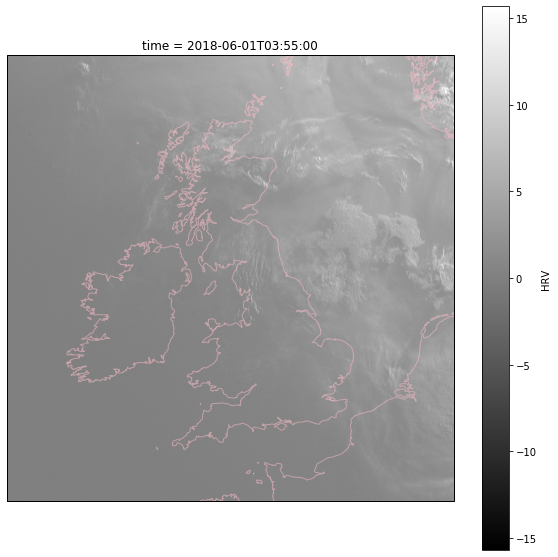

In [27]:
fig = plt.figure(figsize=(10, 10))
crs = ccrs.TransverseMercator()
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', alpha=0.5, color='pink')

data_array.isel(time=11).astype(np.float32).plot.imshow(ax=ax, cmap='gray', origin='upper', add_colorbar=True)